# Overview

This notebook explores dimensionality reduction and visualization of gene expression data using PCA (Principal Component Analysis). The main steps and analyses performed are:

1. **Data Loading**: Clinical metadata, collapsed (not z-scored) gene expression data, and z-scored gene expression data are loaded and aligned by sample.

2. **PCA on Z-Scored Data**: PCA is performed on the full z-scored dataset. The first two principal components are visualized, colored by biological subtype. Variance explained and silhouette scores are calculated to assess separation.

3. **Statistical Testing**: ANOVA is used to test for significant differences in PC1 between subtypes.

4. **Feature Selection**: PCA is repeated using only the top 8000 most variable genes to see if focusing on variable genes improves separation.

5. **Outlier Removal**: Outliers are identified and removed based on PCA distance from the center, and PCA is re-run to assess impact.

6. **PCA on Collapsed Data**: The same PCA workflow is applied to the collapsed (not z-scored) dataset for comparison.


# PCA (Principal Component Analysis)
In the first step, I load both the clinical metadata, the collapsed dataset (that was not zscored), and the z-scored dataset.

## Imports

In [14]:
import os
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import f_oneway, kruskal

import matplotlib.pyplot as plt

In [2]:
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")

repo_root = find_repo_root()

# Load clinical data
clinical_path = repo_root / os.getenv("CLINICAL")
clinical_df = pd.read_csv(clinical_path, index_col=0)

# Load expression (z-scored) data
zscored_path = repo_root / os.getenv("ZSCORED_QUALITY_CHECKED")
zscored_df = pd.read_csv(zscored_path, index_col=0)

# Make sure both dataframes have the same samples and are in the same order
common_samples = clinical_df.index.intersection(zscored_df.index)
clinical_df = clinical_df.loc[common_samples]
zscored_df = zscored_df.loc[common_samples]


collapsed_path = repo_root / os.getenv("EM_COLLAPSED")
collapsed_df = pd.read_csv(collapsed_path, index_col=0)

common_samples = clinical_df.index.intersection(collapsed_df.index)
clinical_df = clinical_df.loc[common_samples]
collapsed_df = collapsed_df.loc[common_samples]

print(f"Zscored data shape: {zscored_df.shape}")
print(f"Collapsed (not zscored) data shape: {collapsed_df.shape}")
print(f"Clinical data shape: {clinical_df.shape}")

Zscored data shape: (3273, 26150)
Collapsed (not zscored) data shape: (3273, 26150)
Clinical data shape: (3273, 34)


## Z-Scored

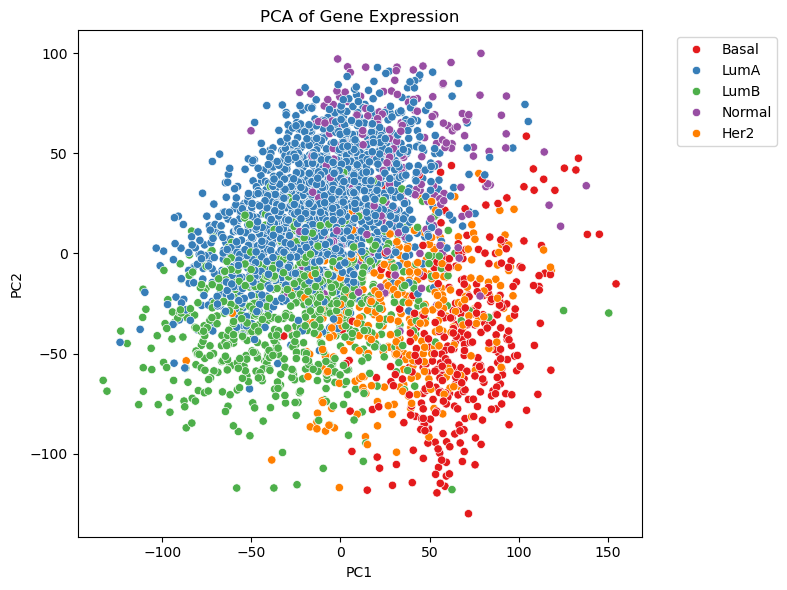

In [3]:
# --- PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(zscored_df.values)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=zscored_df.index)
pca_df = pca_df.join(clinical_df)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2', 
    data=pca_df, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('PCA of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


This PCA doesn't show very nice separation of the subtypes...

In [ ]:
print(f"Explained variance by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Explained variance by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained by PC1 and PC2: {pca.explained_variance_ratio_[:2].sum():.2%}")

# silhouette score for pam50 subtype
label_col = 'OG_pam50 subtype'  
if label_col in clinical_df.columns:
    # Encode labels to integers
    labels = LabelEncoder().fit_transform(clinical_df[label_col].astype(str))
    # Silhouette for PCA embedding
    sil_pca = silhouette_score(pca_result, labels)
    print(f"PCA Silhouette Score (w.r.t {label_col}): {sil_pca:.3f}")
else:
    print(f"No '{label_col}' column found in clinical data; skipping silhouette score.")


Explained variance by PC1: 7.55%
Explained variance by PC2: 6.41%
Total variance explained by PC1 and PC2: 13.97%
PCA Silhouette Score (w.r.t OG_pam50 subtype): 0.061


Only 14% of the variance is explained by the Principal Components 1 and 2.

In [5]:
# Example for PC1 by group
groups = [pca_df['PC1'][pca_df[label_col] == g].values for g in pca_df[label_col].unique()]
anova_p = f_oneway(*groups).pvalue
print(f"ANOVA p-value for PC1 between {label_col} groups: {anova_p:.3e}")


ANOVA p-value for PC1 between OG_pam50 subtype groups: 0.000e+00


### Subsetting

In [6]:
N = 8000
gene_variances = zscored_df.var(axis=0)
top_genes = gene_variances.sort_values(ascending=False).head(N).index
zscored_top = zscored_df[top_genes]

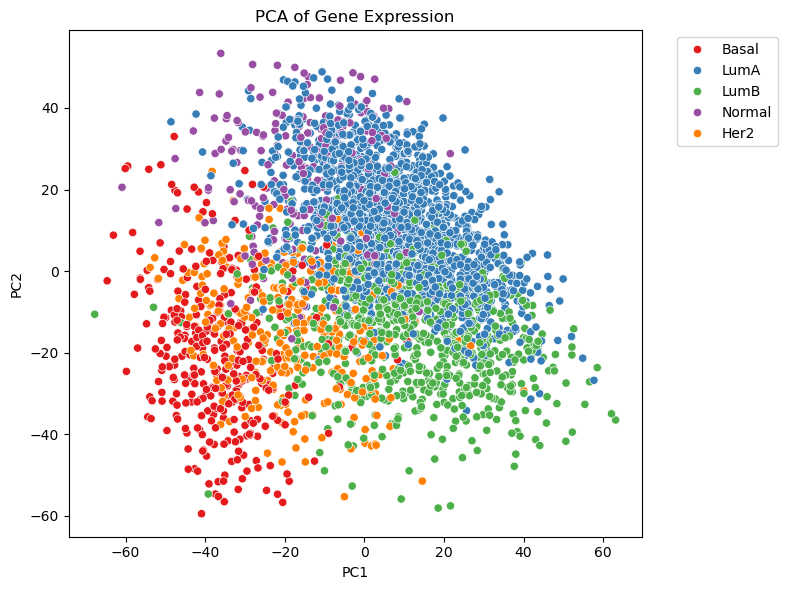

In [7]:
# --- PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(zscored_top.values)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=zscored_top.index)
pca_df = pca_df.join(clinical_df)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2', 
    data=pca_df, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('PCA of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Outlier Removal

F842     72.939587
F1653    72.184324
F2858    71.266590
F1063    68.579149
F1299    67.263665
F2815    66.591775
F3213    66.307059
F286     66.244398
F2461    65.694684
F3085    65.608209
dtype: float64


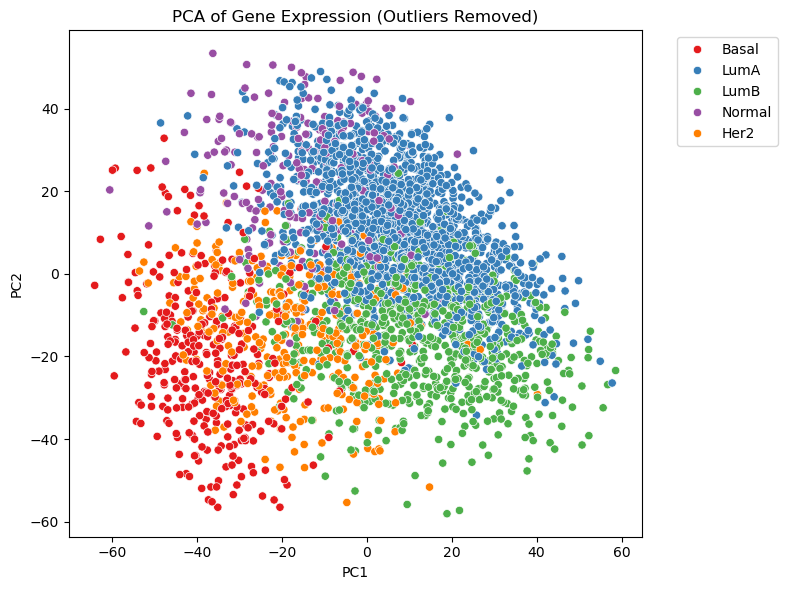

In [ ]:
distances = np.sqrt(pca_df['PC1']**2 + pca_df['PC2']**2)

# 10 outliers with highest distances from center
print(distances.sort_values(ascending=False).head(10))

# Set a threshold (3 standard deviations from mean)
threshold = distances.mean() + 3 * distances.std()
outliers = distances > threshold

# Remove outliers
pca_df_no_outliers = pca_df[~outliers]
filtered_df_no_outliers = zscored_top.loc[pca_df_no_outliers.index]  # Keep only samples left

# Re-run PCA with outliers removed
pca = PCA(n_components=2)
pca_result = pca.fit_transform(filtered_df_no_outliers.values)
pca_df_final = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=filtered_df_no_outliers.index)
pca_df_final = pca_df_final.join(clinical_df)

# Plot again
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2', 
    data=pca_df_final, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('PCA of Gene Expression (Outliers Removed)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Doesn't look better than before.

In [8]:
groups = [pca_df['PC1'][pca_df[label_col] == g].values for g in pca_df[label_col].unique()]
anova_p = f_oneway(*groups).pvalue
print(f"ANOVA p-value for PC1 between {label_col} groups: {anova_p:.3e}")


ANOVA p-value for PC1 between OG_pam50 subtype groups: 0.000e+00


## Collapsed

Performing the same on the collapsed (= not z-scored0) dataframe.

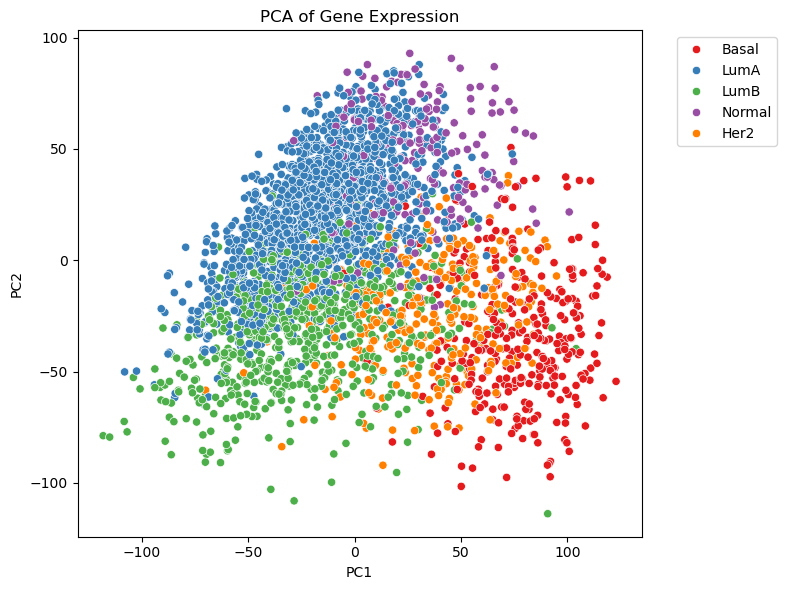

In [9]:
# --- PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(collapsed_df.values)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=collapsed_df.index)
pca_df = pca_df.join(clinical_df)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2', 
    data=pca_df, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('PCA of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
print(f"Explained variance by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Explained variance by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained by PC1 and PC2: {pca.explained_variance_ratio_[:2].sum():.2%}")

# silhouette score for pam50 subtype
label_col = 'OG_pam50 subtype' 
if label_col in clinical_df.columns:
    # Encode labels to integers
    labels = LabelEncoder().fit_transform(clinical_df[label_col].astype(str))
    # Silhouette for PCA embedding
    sil_pca = silhouette_score(pca_result, labels)
    print(f"PCA Silhouette Score (w.r.t {label_col}): {sil_pca:.3f}")
else:
    print(f"No '{label_col}' column found in clinical data; skipping silhouette score.")


Explained variance by PC1: 7.11%
Explained variance by PC2: 5.54%
Total variance explained by PC1 and PC2: 12.65%
PCA Silhouette Score (w.r.t OG_pam50 subtype): 0.095


In [ ]:
groups = [pca_df['PC1'][pca_df[label_col] == g].values for g in pca_df[label_col].unique()]
anova_p = f_oneway(*groups).pvalue
print(f"ANOVA p-value for PC1 between {label_col} groups: {anova_p:.3e}")

ANOVA p-value for PC1 between OG_pam50 subtype groups: 0.000e+00


## Conclusion

PCA does not perform very well in separating the biological subtypes in this dataset.

This is likely because PCA is a linear dimensionality reduction technique that maximizes variance without considering class labels or group structure. 
In high-dimensional gene expression data, the largest sources of variance may be driven by technical noise, batch effects, or other biological factors unrelated to the subtypes of interest. 
As a result, the principal components do not necessarily capture the differences between subtypes, leading to poor separation in the PCA plots and low silhouette scores. Alternative methods such as supervised dimensionality reduction or non-linear techniques (e.g., UMAP, t-SNE) may provide better separation of biologically meaningful groups.

This is why that will be the next steps to take.